In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from pandas import Series
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import warnings;warnings.filterwarnings(action='once')
from colorspacious import cspace_converter
from collections import OrderedDict
from sklearn import preprocessing
from numpy import hstack
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
import matplotlib
matplotlib.rcParams['timezone'] = "UTC" 

large = 25; med = 18; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (20, 10),
          'axes.labelsize': large,
          'axes.titlesize': large,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'timezone':"UTC"}

plt.rcParams.update(params)
sns.set_style("ticks")

# LSTM spliting Function

In [132]:
def split_sequences(sequences,n_steps):
    X,y = list(),list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i +n_steps
        # check if we are beyong the dataset
        
        if end_ix >len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x,seq_y = sequences[i:end_ix,:-1],sequences[end_ix-1,-1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

In [161]:
def adjust_spines(ax,spines):
    
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward',6)) # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none') 

In [198]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Load data
ele = pd.read_csv("data_ne.csv")
ele = ele.drop("Unnamed: 0",axis=1)
ele["time"] = pd.to_datetime(ele["time"])

In [199]:
## date transfer and set index
ele.time = pd.to_datetime(ele.time)
ele.time = pd.DatetimeIndex(ele.time)
ele.set_index("time",inplace = True)

# Data visualization

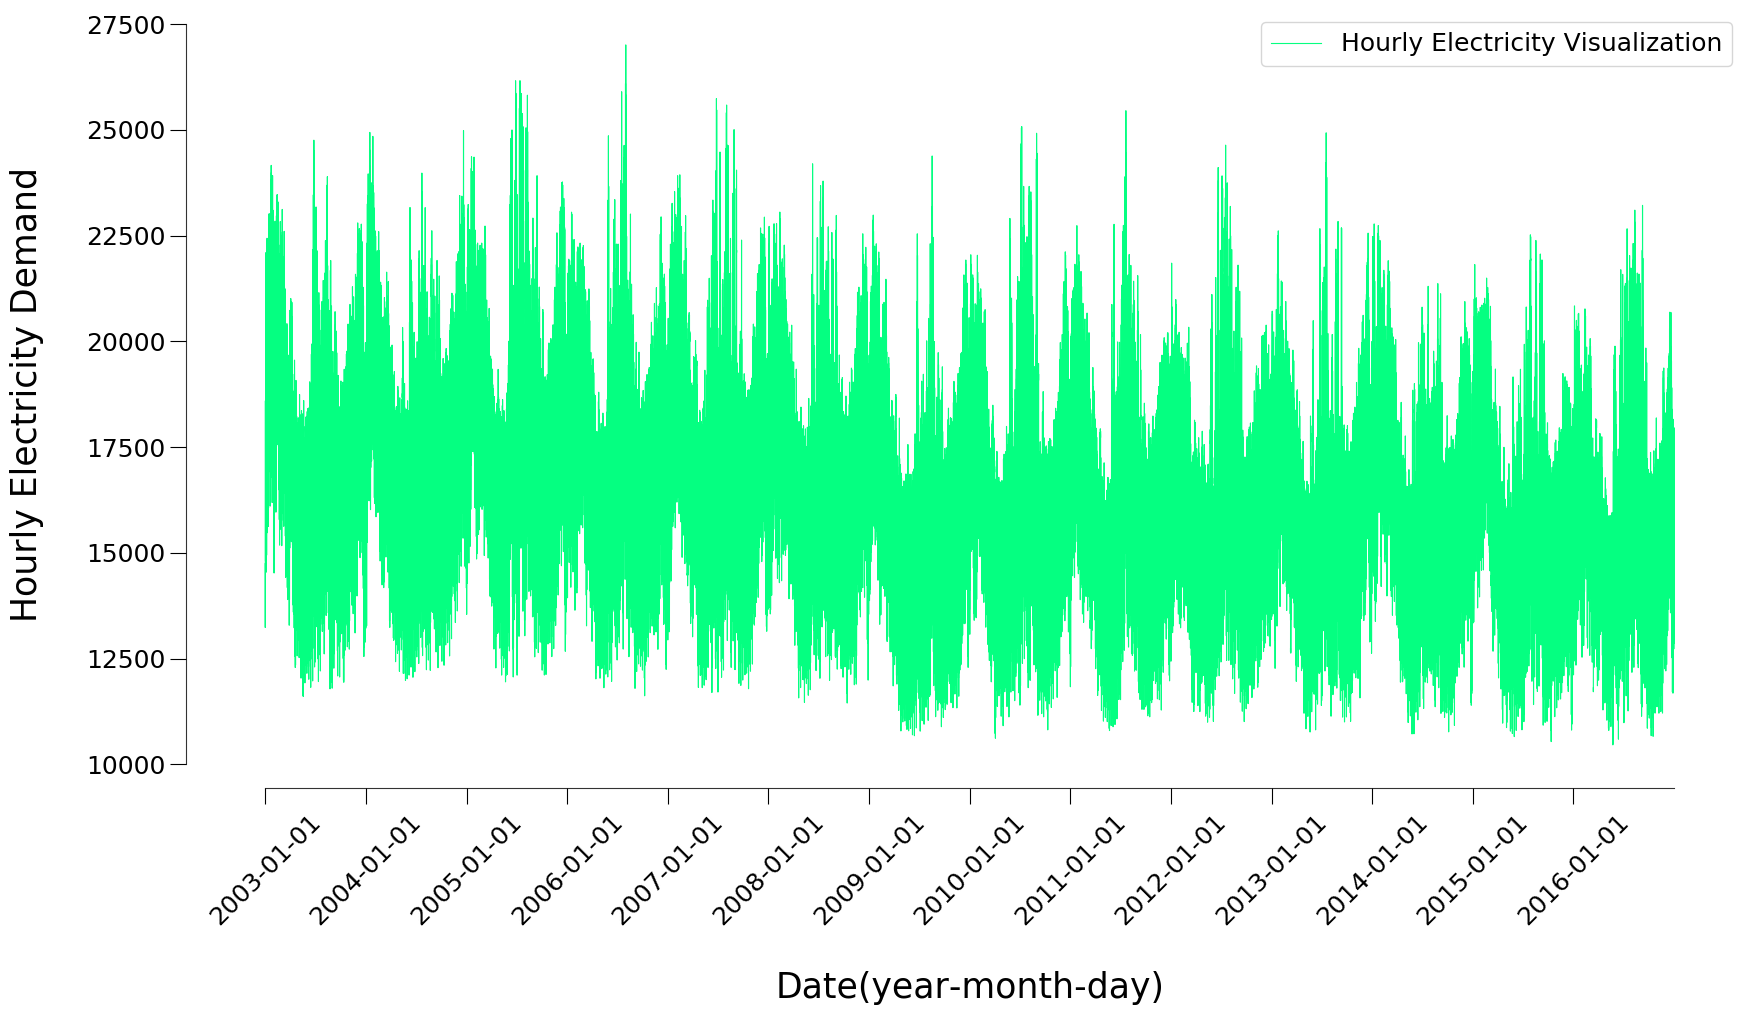

In [222]:
fig, ax = plt.subplots()

positions = [p for p in ele.index
             if p.is_year_start and
             p.hour == 1]

ax.plot(ele['Usage_ma'], label='Hourly Electricity Visualization',linewidth = 0.8,alpha = 0.98,color = "springgreen")

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.8)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.8)

adjust_spines(ax, ['left', 'bottom'])

## set labels and ticks
ax.set_xlabel("Date(year-month-day)")
ax.set_ylabel("Hourly Electricity Demand")
ax.set_xticks(positions)
ax.xaxis.set_tick_params(rotation=45)
ax.tick_params(axis="x", length=11.8)
ax.tick_params(axis="y", length=11.8)

ax.xaxis.labelpad = 30
ax.yaxis.labelpad = 30
plt.legend()
plt.show()

## Data preprocessing

### Define input sequence

In [5]:
ele

,Date,Hour,Year,Month,Usage_ma,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_depth,cloud_cover,air_density,if_holiday,weekend,Max,Min,sta_dev
time,,,,,,,,,,,,,,,,,,
2003-01-01 01:00:00,2003-01-01,1,2003,1,14745.000,0.010,-1.720,0.000,0.000,0.001,17.431,0.320,1.261,True,False,18594.000,13236.000,1789.888
2003-01-01 02:00:00,2003-01-01,2,2003,1,14280.000,0.002,-2.045,0.000,0.000,0.001,17.431,0.317,1.264,True,False,18594.000,13236.000,1789.888
2003-01-01 03:00:00,2003-01-01,3,2003,1,13821.000,0.001,-2.402,0.000,0.000,0.001,17.430,0.296,1.267,True,False,18594.000,13236.000,1789.888
2003-01-01 04:00:00,2003-01-01,4,2003,1,13239.000,0.001,-2.732,0.000,0.000,0.001,17.430,0.374,1.270,True,False,18594.000,13236.000,1789.888
2003-01-01 05:00:00,2003-01-01,5,2003,1,13236.000,0.001,-3.083,0.000,0.000,0.001,17.430,0.607,1.272,True,False,18594.000,13236.000,1789.888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 20:00:00,2016-12-31,20,2016,12,16260.000,0.164,0.551,65.795,394.877,0.085,16.957,0.976,1.241,False,True,17340.000,12861.000,1318.496
2016-12-31 21:00:00,2016-12-31,21,2016,12,15658.000,0.186,0.455,29.811,238.015,0.086,16.960,0.973,1.241,False,True,17340.000,12861.000,1318.496
2016-12-31 22:00:00,2016-12-31,22,2016,12,15195.000,0.232,0.180,4.850,52.937,0.105,16.968,0.963,1.242,False,True,17340.000,12861.000,1318.496


In [6]:
#for year in years: 
columns = ["Hour","Year","Month","temperature","if_holiday","weekend"]

X = ele.loc[:,columns]
y = ele.loc[:,"Usage_ma"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,shuffle = False)

In [7]:
X_train_1 = X_train.drop(["if_holiday","weekend"],axis=1)

X_train_2 = X_train[["if_holiday","weekend"]].astype('category')

X_test_1 = X_test.drop(["if_holiday","weekend"],axis=1)

X_test_2 = X_test[["if_holiday","weekend"]].astype('category')

## column names
X_name = X_train.columns

X_train_1_scale = preprocessing.scale(X_train_1)
X_test_1_scale = preprocessing.scale(X_test_1)

## concatenate numeric scaling and categorical variables
concate_train = np.hstack((X_train_2,X_train_1_scale))
concate_test = np.hstack((X_test_2,X_test_1_scale))

In [8]:
X_train_1

,Hour,Year,Month,temperature
time,,,,
2003-01-01 01:00:00,1,2003,1,-1.720
2003-01-01 02:00:00,2,2003,1,-2.045
2003-01-01 03:00:00,3,2003,1,-2.402
2003-01-01 04:00:00,4,2003,1,-2.732
2003-01-01 05:00:00,5,2003,1,-3.083
...,...,...,...,...
2012-05-19 05:00:00,5,2012,5,10.593
2012-05-19 06:00:00,6,2012,5,10.195
2012-05-19 07:00:00,7,2012,5,9.955


## DataFrame transformation

In [10]:

train_scale = pd.DataFrame(data = concate_train,columns = ["if_holiday","weekend","Hour","Year","Month","temperature"])
test_scale = pd.DataFrame(data = concate_test,columns = ["if_holiday","weekend","Hour","Year","Month","temperature"])

train_scale[["Hour","Year","Month","if_holiday","weekend"]] =train_scale[["Hour","Year","Month","if_holiday","weekend"]].astype('category')
test_scale[["Hour","Year","Month","if_holiday","weekend"]] =test_scale[["Hour","Year","Month","if_holiday","weekend"]].astype('category')

train_scale["temperature"] = train_scale["temperature"].astype("float64")
test_scale["temperature"] = test_scale["temperature"].astype("float64")

In [11]:
# input
in_seq1 = concate_train[:,0]
in_seq2 = concate_train[:,1]
in_seq3 = concate_train[:,2]
in_seq4 = concate_train[:,3]
in_seq5 = concate_train[:,4]
in_seq6 = concate_train[:,5]

# output
out_seq_train = np.array(y_train)

In [12]:
# input
in_seq_1 = concate_test[:,0]
in_seq_2 = concate_test[:,1]
in_seq_3 = concate_test[:,2]
in_seq_4 = concate_test[:,3]
in_seq_5 = concate_test[:,4]
in_seq_6 = concate_test[:,5]

# output
out_seq_test = np.array(y_test)

In [18]:
## convert to [rows,columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1),1))
in_seq2 = in_seq2.reshape((len(in_seq2),1))
in_seq3 = in_seq3.reshape((len(in_seq1),1))
in_seq4 = in_seq4.reshape((len(in_seq4),1))
in_seq5 = in_seq5.reshape((len(in_seq4),1))
in_seq6 = in_seq6.reshape((len(in_seq5),1))


out_seq = out_seq_train.reshape((len(in_seq1),1))

# horizontally stack columns
dataset = hstack((in_seq1,in_seq2,in_seq3,in_seq4,in_seq5,in_seq6,out_seq))

In [19]:
in_seq_1 = in_seq_1.reshape((len(in_seq_1),1))
in_seq_2 = in_seq_2.reshape((len(in_seq_2),1))
in_seq_3 = in_seq_3.reshape((len(in_seq_2),1))
in_seq_4 = in_seq_4.reshape((len(in_seq_4),1))
in_seq_5 = in_seq_5.reshape((len(in_seq_5),1))
in_seq_6 = in_seq_6.reshape((len(in_seq_6),1))


out_seq_test = out_seq_test.reshape((len(in_seq_1),1))

# horizontally stack columns
dataset_1 = hstack((in_seq_1,in_seq_2,in_seq_3,in_seq_4,in_seq_5,in_seq_6,out_seq_test))

In [22]:
n_steps = 3
n_features = 6
X, y = split_sequences(dataset,n_steps)
X_test,y_test = split_sequences(dataset_1,n_steps)

## Define model

In [24]:
model  = Sequential()
model.add(LSTM(64,activation = "relu",input_shape = (n_steps,n_features)))
#model.add(Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.3, activation='relu',input_shape = (n_steps,n_features))))
#model.add(LSTM(64, return_sequences = True))
model.add(Dense(1))
model.compile(optimizer = 'adam',loss = "mae")

In [25]:
import timeit

epoches = [epoch for epoch in range(1,200,10)]
maes = []
for epoch in epoches:
    start = timeit.default_timer()

    model.fit(X,y,epochs = 10,verbose=0) 
    
    # test predictions
    yhat_test = model.predict(X_test.reshape(40501,3,6),verbose = 0)
    #x_testing
    yhat_2 = model.predict(X_test.reshape(40501,3,6),verbose = 0)
    
    y_test
    
    mae = np.mean(abs(y_test - yhat_test.reshape(40501,)))
    
    stop = timeit.default_timer()
    print("The mae of the LISM model at {} epoch is {} with running time at {}".format(epoch,mae,stop - start)) 
    

C:\Users\xfu3\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


The mae of the LISM model at 1 epoch is 1159.1546083063536 with running time at 79.75257489999996
The mae of the LISM model at 11 epoch is 1110.0117707838233 with running time at 78.11402540000006
The mae of the LISM model at 21 epoch is 1215.3502595084458 with running time at 75.31496010000001
The mae of the LISM model at 31 epoch is 1091.5108543326862 with running time at 79.61291900000003
The mae of the LISM model at 41 epoch is 1155.0942777406344 with running time at 86.52013480000005
The mae of the LISM model at 51 epoch is 1156.3837373662457 with running time at 84.58717409999997
The mae of the LISM model at 61 epoch is 1143.1371988693181 with running time at 82.9646189
The mae of the LISM model at 71 epoch is 1129.7985654723418 with running time at 75.0886855
The mae of the LISM model at 81 epoch is 1099.6531774967748 with running time at 75.25418460000003
The mae of the LISM model at 91 epoch is 1207.3896732488088 with running time at 74.98534390000009
The mae of the LISM model

In [26]:
yhat_2.reshape(40501,)

array([15716.1   , 15501.43  , 15194.869 , ..., 16930.44  , 16088.0205,
       14866.515 ], dtype=float32)

In [27]:
y_test-yhat_2.reshape(40501,)

array([-1206.09960938, -1032.4296875 ,  -529.86914062, ...,
       -1735.43945312, -1330.02050781,  -713.51464844])

**x_training**

In [32]:
yhat_1 = model.predict(X.reshape(82231,3,6),verbose = 0)

**x_testing**

In [34]:
yhat_2 = model.predict(X_test.reshape(40501,3,6),verbose = 0)

### plot of training set (the first 1000 predictions)

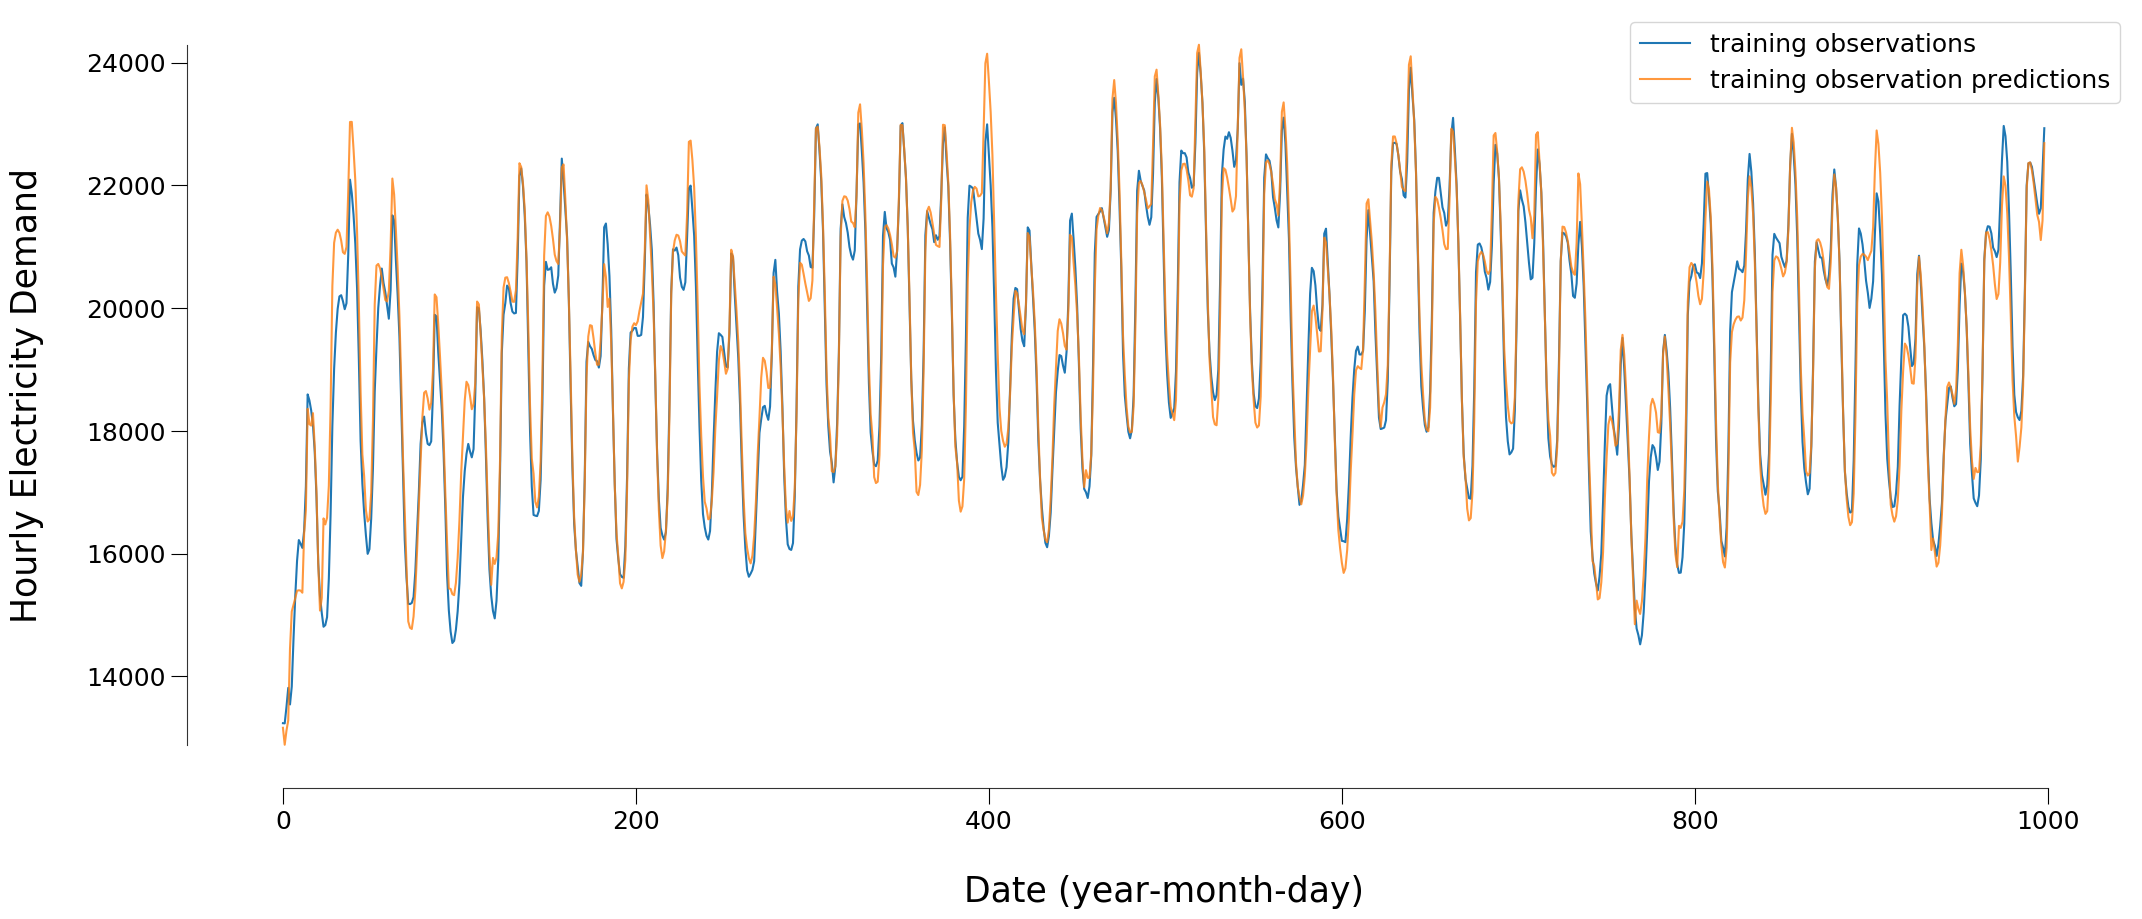

In [227]:
## training visualization
fig, ax = plt.subplots(figsize = (25,10))
ax.plot(y[1:1000],label = "training observations")
ax.plot(yhat_1[1:1000],label = "training observation predictions",alpha = 0.8)

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.8)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.8)

## set labels and ticks
adjust_spines(ax, ['left', 'bottom'])
ax.set_xlabel("Date (year-month-day)")
ax.set_ylabel("Hourly Electricity Demand")
ax.tick_params(axis="x", length=11.8)
ax.tick_params(axis="y", length=11.8)

ax.xaxis.labelpad = 30
ax.yaxis.labelpad = 30

plt.legend()
plt.show()

### Plot of Test set 

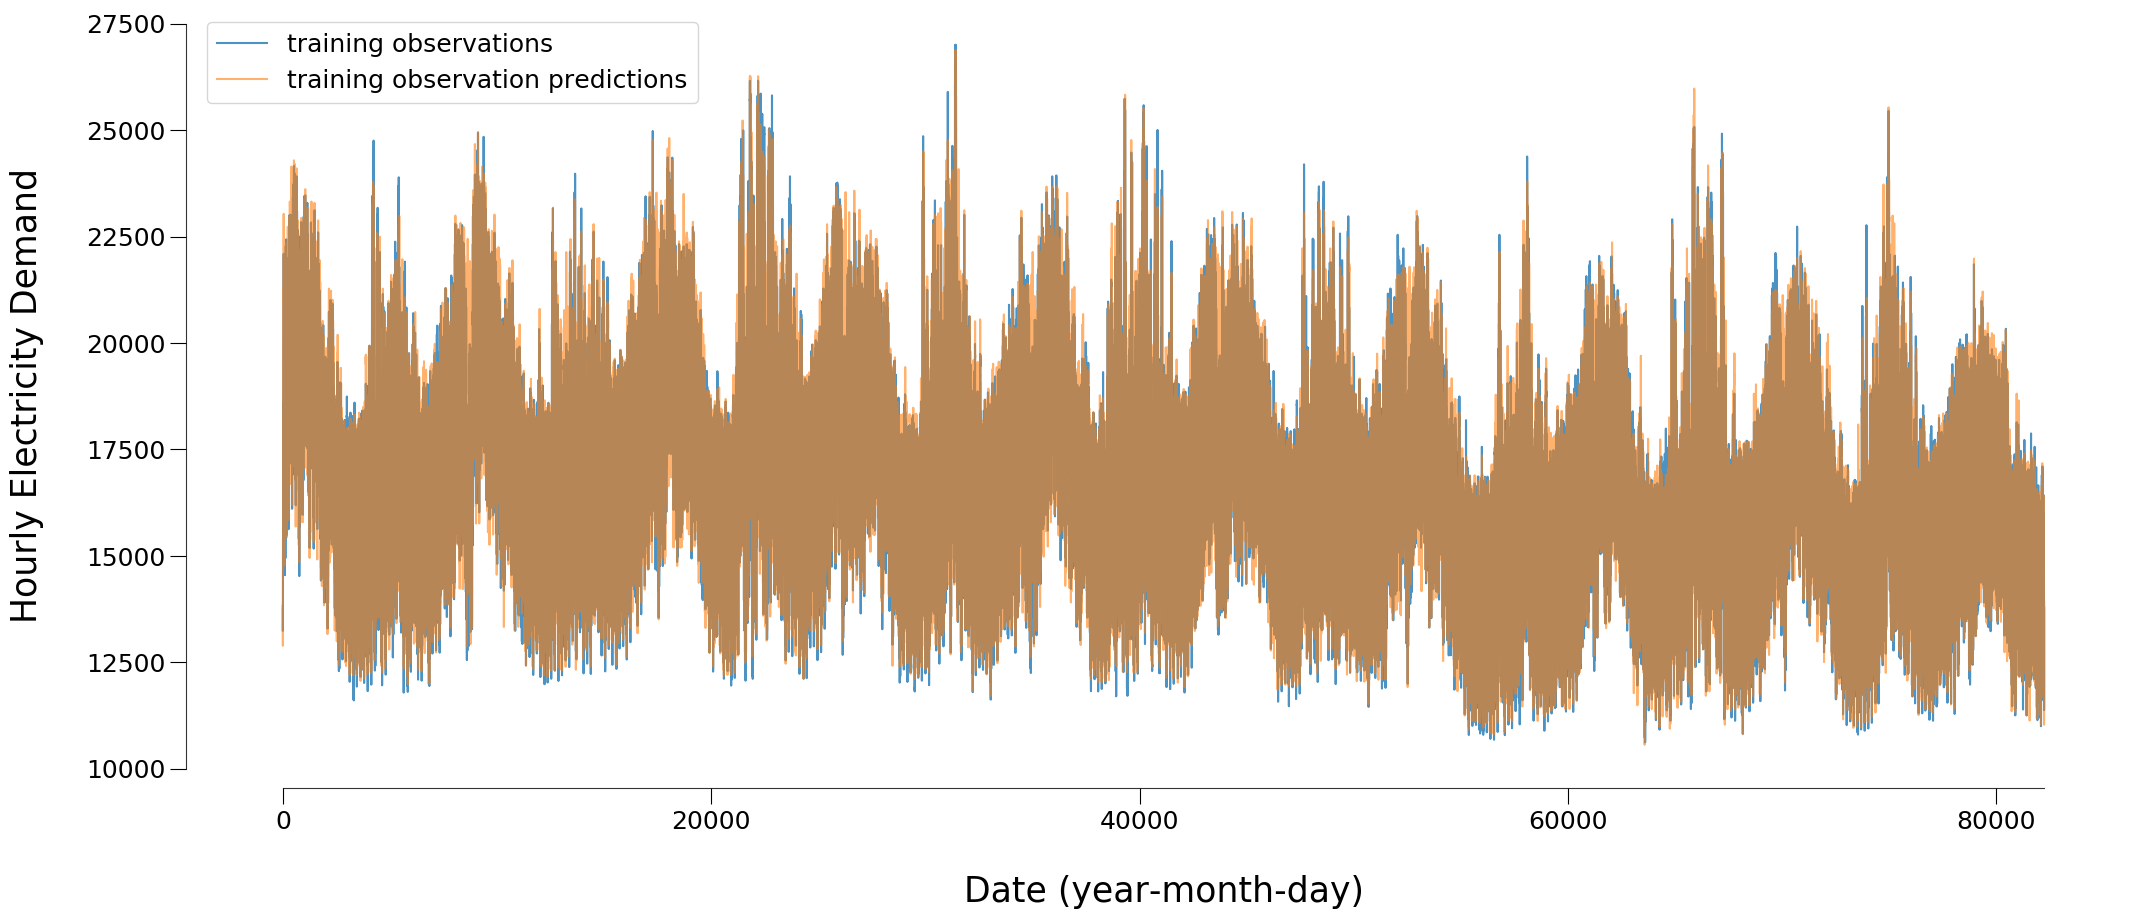

In [231]:
## training visualization
fig, ax = plt.subplots(figsize = (25,10))
ax.plot(y,label = "training observations",alpha = 0.8)
ax.plot(yhat_1,label = "training observation predictions",alpha = 0.6)

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.8)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.8)

## set labels and ticks
adjust_spines(ax, ['left', 'bottom'])
ax.set_xlabel("Date (year-month-day)")
ax.set_ylabel("Hourly Electricity Demand")
ax.tick_params(axis="x", length=11.8)
ax.tick_params(axis="y", length=11.8)

ax.xaxis.labelpad = 30
ax.yaxis.labelpad = 30

plt.legend()
plt.show()

## Data transformation

In [ ]:
def dat_trans(test_year):

    columns = ["Hour","Year","Month","temperature","if_holiday","weekend"]
    
    X = ele.loc[:,columns]
    y = ele.loc[:,"Usage_ma"]

    X_train = ele.loc[ele.Year < test_year,columns]
    y_train = ele.loc[ele.Year < test_year,"Usage_ma"]

    X_test = ele.loc[ele.Year == test_year,columns]
    y_test = ele.loc[ele.Year == test_year,"Usage_ma"]
    
    X_train_1 = X_train.drop(["if_holiday","weekend"],axis=1)

    X_train_2 = X_train[["if_holiday","weekend"]].astype('category')

    X_test_1 = X_test.drop(["if_holiday","weekend"],axis=1)

    X_test_2 = X_test[["if_holiday","weekend"]].astype('category')

    ## column names
    X_name = X_train.columns

    X_train_1_scale = preprocessing.scale(X_train_1)
    X_test_1_scale = preprocessing.scale(X_test_1)

    ## concatenate numeric scaling and categorical variables
    concate_train = np.hstack((X_train_2,X_train_1_scale))
    concate_test = np.hstack((X_test_2,X_test_1_scale))
    
    ## DataFrame transformation
    train_scale = pd.DataFrame(data = concate_train,columns = ["if_holiday","weekend","Hour","Year","Month","temperature"])
    test_scale = pd.DataFrame(data = concate_test,columns = ["if_holiday","weekend","Hour","Year","Month","temperature"])

    train_scale[["if_holiday","weekend"]] =train_scale[["if_holiday","weekend"]].astype('category')
    test_scale[["if_holiday","weekend"]] =test_scale[["if_holiday","weekend"]].astype('category')

    train_scale["temperature"] = train_scale["temperature"].astype("float64")
    test_scale["temperature"] = test_scale["temperature"].astype("float64")
    
    # input (training)
    in_seq1 = concate_train[:,0]
    in_seq2 = concate_train[:,1]
    in_seq3 = concate_train[:,2]
    in_seq4 = concate_train[:,3]
    in_seq5 = concate_train[:,4]
    in_seq6 = concate_train[:,5]

    # output (training)
    out_seq_train = np.array(y_train)
    
    # input (testing)
    in_seq_1 = concate_test[:,0]
    in_seq_2 = concate_test[:,1]
    in_seq_3 = concate_test[:,2]
    in_seq_4 = concate_test[:,3]
    in_seq_5 = concate_test[:,4]
    in_seq_6 = concate_test[:,5]

    # output (testing)
    out_seq_test = np.array(y_test)
    
    ## convert to [rows,columns] structure
    in_seq1 = in_seq1.reshape((len(in_seq1),1))
    in_seq2 = in_seq2.reshape((len(in_seq2),1))
    in_seq3 = in_seq3.reshape((len(in_seq3),1))
    in_seq4 = in_seq4.reshape((len(in_seq4),1))
    in_seq5 = in_seq5.reshape((len(in_seq5),1))
    in_seq6 = in_seq6.reshape((len(in_seq6),1))

    out_seq = out_seq_train.reshape((len(in_seq1),1))

    # horizontally stack columns
    dataset = hstack((in_seq1,in_seq2,in_seq3,in_seq4,in_seq5,in_seq6,out_seq))
    
    in_seq_1 = in_seq_1.reshape((len(in_seq_1),1))
    in_seq_2 = in_seq_2.reshape((len(in_seq_2),1))
    in_seq_3 = in_seq_3.reshape((len(in_seq_3),1))
    in_seq_4 = in_seq_4.reshape((len(in_seq_4),1))
    in_seq_5 = in_seq_5.reshape((len(in_seq_5),1))
    in_seq_6 = in_seq_6.reshape((len(in_seq_6),1))


    out_seq_test = out_seq_test.reshape((len(in_seq_1),1))

    # horizontally stack columns
    dataset_1 = hstack((in_seq_1,in_seq_2,in_seq_3,in_seq_4,in_seq_5,in_seq_6,out_seq_test))
    
    return dataset,dataset_1 

## Nested cross validation [link](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9)

In [17]:
years = [i for i in range(2004,2017)]
years
shap = 8758

n_steps = 3
n_features = 6
maes = []

for year in years:
    dat_train, dat_test = dat_trans(year)
    X, y = split_sequences(dat_train,n_steps)
    X_test,y_test = split_sequences(
        dat_test,n_steps)
    
    ## model building
    model  = Sequential()
    model.add(Bidirectional(LSTM(32, activation='relu',input_shape = (n_steps,n_features))))
    model.add(Dense(1))
    model.compile(optimizer = 'adam',loss = "mae")

    model.fit(X,y,epochs = 10,verbose=0) 
        
    
    if year % 4 == 0:
        shap = 8782
    else:
        shap = 8758
        
        
    # test predictions
    yhat_test = model.predict(X_test.reshape(shap,3,6),verbose = 0)
    #x_testing
    yhat_2 = model.predict(X_test.reshape(shap,3,6),verbose = 0)
    
    mae = abs(np.sum(y_test) - np.sum(yhat_2))
    maes.append(mae)

print(np.mean(maes))


10246503.692307692


## Evaluation metric [link](https://ssc.ca/en/case-study/predicting-hourly-electricity-demand-ontario)

In [15]:
np.mean(maes)*0.0000036

34.763475323076925